In [1]:
import pandas as pd 
import pickle
import numpy as np
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import xgboost as xgb
from tensorflow.keras.layers import LSTM

from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
import random

In [2]:
data = []
with (open("saved_results/clients_data_full", "rb")) as openfile:
    while True:
        try:
            data.append(pickle.load(openfile))
        except EOFError:
            break

In [3]:
#One dataframe per household
dfs_train = [None]*25
dfs_test = [None]*25
dfs_big = [None]*25

for i in range(len(data[0])):
    #Create train dfs
    mat_train = np.matrix(data[0][i][0])
    dfs_train[i] = pd.DataFrame(mat_train)
    dfs_train[i].drop(7, axis = 1, inplace = True)
    dfs_train[i]['pred'] = data[0][i][1].tolist()
    
    #Create test dfs
    mat = np.matrix(data[0][i][2])
    dfs_test[i] = pd.DataFrame(mat)
    dfs_test[i].drop(7, axis = 1, inplace = True)
    dfs_test[i]['pred'] = data[0][i][3].tolist()
    
    dfs_big[i] = dfs_train[i].append(dfs_test[i])
    dfs_big[i] = (dfs_big[i]-dfs_big[i].mean())/dfs_big[i].std()
    
    

## Linear model on big dataset

In [70]:
#One model per household
r_2 = [None]*len(dfs_train)
mserror = [None]*len(dfs_train)
for i in range(len(dfs_train)):
    X = dfs_big[i].loc[:, dfs_big[i].columns != 'pred']


    y = dfs_big[i].loc[:, dfs_big[i].columns == 'pred']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)

    y_pred = regr.predict(X_test)
    
    r_2[i] = 1-(1-r2_score(y_test, y_pred))*((len(X_test)-1)/(len(X_test)-len(X_test.columns)-1))
    mserror[i] = mean_squared_error(y_test, y_pred)
    
    
r2_adj = np.mean(r_2)
std = (np.std(r_2)/r2_adj)*100
mse = np.mean(mserror)

print("Adjusted R2 : " + r2_adj.astype(str) + "\nMSE : " + mse.astype(str) + " +- " + std.astype(str) + "%")

Adjusted R2 : 0.7260501387246925
MSE : 0.26506222010465325 +- 6.7702466458943515%


## Linear model on varying dataset size 

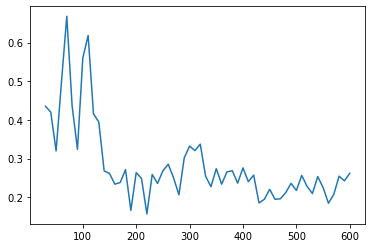

In [75]:
step = 10

#One model per household
r_2 = [None]*len(dfs_train)
mserror = [None]*len(dfs_train)
dfs_bigs = [None]*len(dfs_big)
r2_adj = [None]*len(range(30, len(dfs_big[1]), step))
mse_lin = [None]*len(range(30, len(dfs_big[1]), step))

j = 0
for n in range(30, len(dfs_big[1]), step):
    for i in range(len(dfs_train)):

        dfs_bigs[i] = dfs_big[i].sample(n, replace = True, random_state=1)
        
        X = dfs_bigs[i].loc[:, dfs_bigs[i].columns != 'pred']


        y = dfs_bigs[i].loc[:, dfs_bigs[i].columns == 'pred']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


        regr = linear_model.LinearRegression()
        regr.fit(X_train, y_train)

        y_pred = regr.predict(X_test)


        #r_2[i] = 1-(1-r2_score(y_test, y_pred))*((len(X_test)-1)/(len(X_test)-len(X_test.columns)-1))
        mserror[i] = mean_squared_error(y_test, y_pred)

    #r2_adj[j] = np.mean(r_2)
    mse_lin[j] = np.mean(mserror)
    j += 1

plt.figure()
plt.plot(list(range(30, len(dfs_big[1]), step)), mse_lin)


## XGBoost on big dataset 

In [76]:
#One model per household
r_2 = [None]*len(dfs_train)
mserror = [None]*len(dfs_train)
std = [None]*len(dfs_train)


for i in range(len(dfs_train)):
    X = dfs_big[i].loc[:, dfs_big[i].columns != 'pred']


    y = dfs_big[i].loc[:, dfs_big[i].columns == 'pred']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    

    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                    max_depth = 4, alpha = 4, n_estimators = 300)

    xg_reg.fit(X_train, y_train)
    y_pred = xg_reg.predict(X_test)


    r_2[i] = 1-(1-r2_score(y_test, y_pred))*((len(X_test)-1)/(len(X_test)-len(X_test.columns)-1))
    mserror[i] = mean_squared_error(y_test, y_pred)
    
    
r2_adj = np.mean(r_2)
std = (np.std(r_2)/r2_adj)*100
mse = np.mean(mserror)

print("Adjusted R2 : " + r2_adj.astype(str) + "\nMSE : " + mse.astype(str) + " +- " + std.astype(str) + "%")

Adjusted R2 : 0.7074443283693883
MSE : 0.2826007873070077 +- 8.340097559326157%


## XGBoost on varying dataset size 

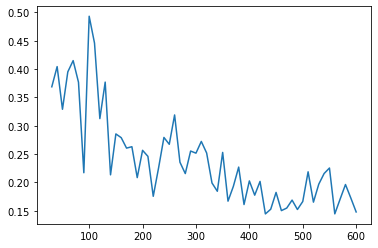

In [78]:
step = 10

#One model per household
r_2 = [None]*len(dfs_train)
mserror = [None]*len(dfs_train)
dfs_bigs = [None]*len(dfs_big)
r2_adj = [None]*len(range(30, len(dfs_big[1]), step))
mse = [None]*len(range(30, len(dfs_big[1]), step))

j = 0
for n in range(30, len(dfs_big[1]), step):
    for i in range(len(dfs_train)):

        dfs_bigs[i] = dfs_big[i].sample(n, replace = True, random_state=1)
        
        X = dfs_bigs[i].loc[:, dfs_bigs[i].columns != 'pred']


        y = dfs_bigs[i].loc[:, dfs_bigs[i].columns == 'pred']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


        xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                        max_depth = 4, alpha = 4, n_estimators = 300)

        xg_reg.fit(X_train, y_train)
        y_pred = xg_reg.predict(X_test)


        #r_2[i] = 1-(1-r2_score(y_test, y_pred))*((len(X_test)-1)/(len(X_test)-len(X_test.columns)-1))
        mserror[i] = mean_squared_error(y_test, y_pred)

    #r2_adj[j] = np.mean(r_2)
    mse[j] = np.mean(mserror)
    j += 1

plt.figure()
plt.plot(list(range(30, len(dfs_big[1]), step)), mse)


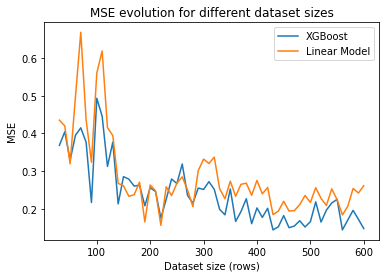

In [82]:
plt.figure()
plt.title("MSE evolution for different dataset sizes")
plt.xlabel("Dataset size (rows)")
plt.ylabel("MSE")
plt.plot(list(range(30, len(dfs_big[1]), step)), mse,label = "XGBoost")
plt.plot(list(range(30, len(dfs_big[1]), step)), mse_lin, label = "Linear Model")
plt.legend()

The knee is at approx 150

### Get the values N = 150

In [86]:
mserror = [None]*len(dfs_train)
for i in range(len(dfs_train)):

        dfs_bigs[i] = dfs_big[i].sample(150, replace = True, random_state=1)
        
        X = dfs_bigs[i].loc[:, dfs_bigs[i].columns != 'pred']


        y = dfs_bigs[i].loc[:, dfs_bigs[i].columns == 'pred']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


        regr = linear_model.LinearRegression()
        regr.fit(X_train, y_train)

        y_pred = regr.predict(X_test)


        #r_2[i] = 1-(1-r2_score(y_test, y_pred))*((len(X_test)-1)/(len(X_test)-len(X_test.columns)-1))
        mserror[i] = mean_squared_error(y_test, y_pred)

print(str(np.mean(mserror)) + " +- " + str(np.std(mserror)))

0.2614901774100218 +- 0.10082863984851463


In [87]:
mserror = [None]*len(dfs_train)
for i in range(len(dfs_train)):

        dfs_bigs[i] = dfs_big[i].sample(150, replace = True, random_state=1)
        
        X = dfs_bigs[i].loc[:, dfs_bigs[i].columns != 'pred']


        y = dfs_bigs[i].loc[:, dfs_bigs[i].columns == 'pred']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


        xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                        max_depth = 4, alpha = 4, n_estimators = 300)

        xg_reg.fit(X_train, y_train)
        y_pred = xg_reg.predict(X_test)


        #r_2[i] = 1-(1-r2_score(y_test, y_pred))*((len(X_test)-1)/(len(X_test)-len(X_test.columns)-1))
        mserror[i] = mean_squared_error(y_test, y_pred)
        
print(str(np.mean(mserror)) + " +- " + str(np.std(mserror)))

0.28565424581304927 +- 0.06675474156069107


### Get the values N = 100

In [115]:
mserror = [None]*len(dfs_train)
for i in range(len(dfs_train)):

        dfs_bigs[i] = dfs_big[i].sample(100, replace = True, random_state=1)
        
        X = dfs_bigs[i].loc[:, dfs_bigs[i].columns != 'pred']


        y = dfs_bigs[i].loc[:, dfs_bigs[i].columns == 'pred']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


        regr = linear_model.LinearRegression()
        regr.fit(X_train, y_train)

        y_pred = regr.predict(X_test)


        #r_2[i] = 1-(1-r2_score(y_test, y_pred))*((len(X_test)-1)/(len(X_test)-len(X_test.columns)-1))
        mserror[i] = mean_squared_error(y_test, y_pred)

print(str(np.mean(mserror)) + " +- " + str(np.std(mserror)))

0.5597822753791009 +- 0.14051852297349662


In [116]:
mserror = [None]*len(dfs_train)
for i in range(len(dfs_train)):

        dfs_bigs[i] = dfs_big[i].sample(100, replace = True, random_state=1)
        
        X = dfs_bigs[i].loc[:, dfs_bigs[i].columns != 'pred']


        y = dfs_bigs[i].loc[:, dfs_bigs[i].columns == 'pred']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


        xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                        max_depth = 4, alpha = 4, n_estimators = 300)

        xg_reg.fit(X_train, y_train)
        y_pred = xg_reg.predict(X_test)


        #r_2[i] = 1-(1-r2_score(y_test, y_pred))*((len(X_test)-1)/(len(X_test)-len(X_test.columns)-1))
        mserror[i] = mean_squared_error(y_test, y_pred)
        
print(str(np.mean(mserror)) + " +- " + str(np.std(mserror)))

0.49321683207423184 +- 0.10290210436540544


## Pytorch FedAvg

### For N = 150 

In [100]:
data = []
test = []
df = [None]*len(dfs_big)


for i in range(len(dfs_big)):
    df[i] = dfs_big[i].sample(n = 150)
    X = df[i].loc[:, df[i].columns != 'pred']


    y = df[i].loc[:, df[i].columns == 'pred']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    
    data.append((X_train.to_numpy(),y_train.to_numpy()))
    test.append((X_test.to_numpy(),y_test.to_numpy()))

N = len(dfs_big)
iterations = 10000
S = 20
n_feat = 13

for i in range(len(data)): 
    x_i = torch.FloatTensor(data[i][0])
    y_i = torch.FloatTensor(data[i][1])
    data[i] = (x_i,y_i)

out_model, hist = fed_sgd(data, iterations, N, S, n_feat)

In [101]:
mses = []
loss_fn = nn.MSELoss()
for i in range(len(test)): 
    predictions = out_model(torch.FloatTensor(test[i][0]))

    mses.append(loss_fn(predictions, torch.FloatTensor(test[i][1])))



for i in range(len(mses)):
    mses[i] = mses[i].detach().numpy()

print(str(np.mean(mses)) + ' +- ' + str(np.std(mses)))

0.22874415 +- 0.08830795


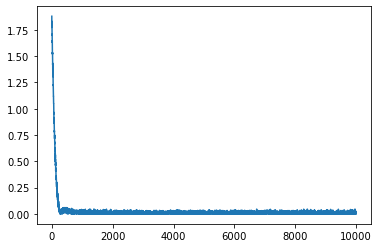

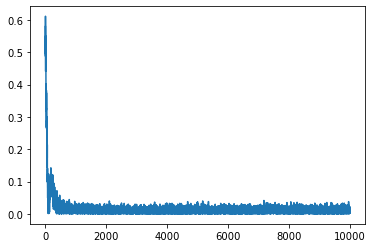

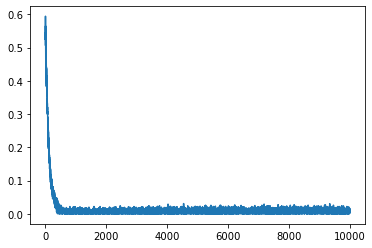

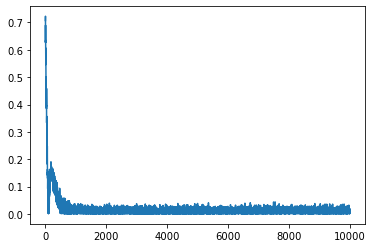

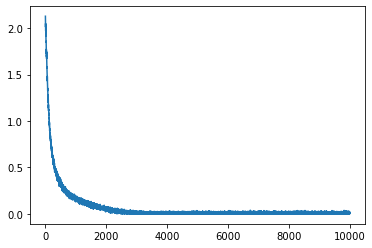

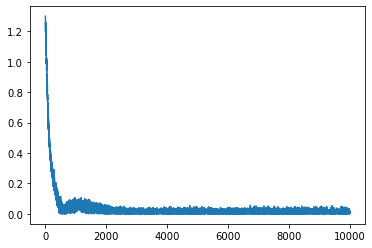

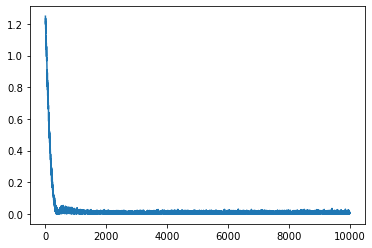

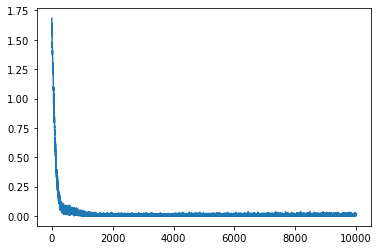

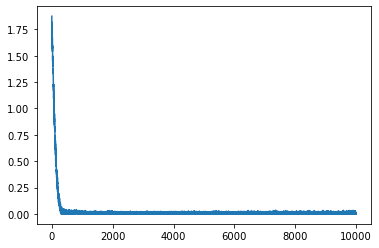

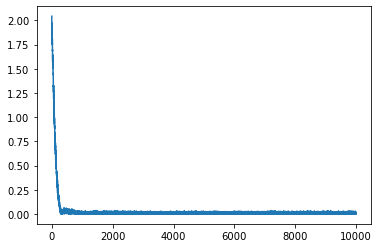

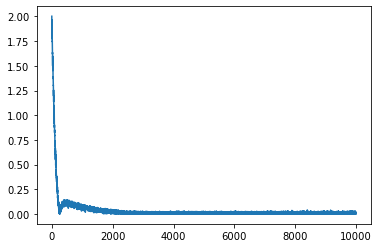

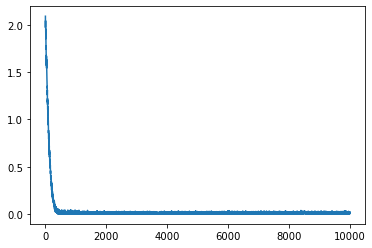

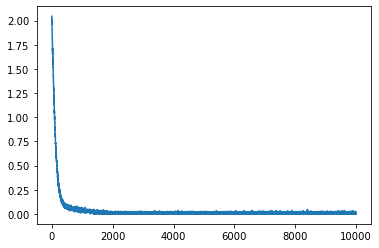

In [111]:
for i in range(0,13):
    al = np.stack(hist, axis=0)[:,0][:,i]
    plt.figure()
    plt.plot(range(0,len(al)), np.abs(al))


### For N = 100

In [62]:
data = []
test = []
df = [None]*len(dfs_big)


for i in range(len(dfs_big)):
    df[i] = dfs_big[i].sample(n = 100)
    X = df[i].loc[:, df[i].columns != 'pred']


    y = df[i].loc[:, df[i].columns == 'pred']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    
    data.append((X_train.to_numpy(),y_train.to_numpy()))
    test.append((X_test.to_numpy(),y_test.to_numpy()))

N = len(dfs_big)
iterations = 10000
S = 20
n_feat = 13

for i in range(len(data)): 
    x_i = torch.FloatTensor(data[i][0])
    y_i = torch.FloatTensor(data[i][1])
    x_t_i = torch.FloatTensor(test[i][0])
    y_t_i = torch.FloatTensor(test[i][1])
    data[i] = (x_i,y_i)
    testing[i] = (x_t_i,y_t_i)

out_model, loss_100, loss_t_100, hist = fed_sgd(data, testing,  iterations, N, S, n_feat)

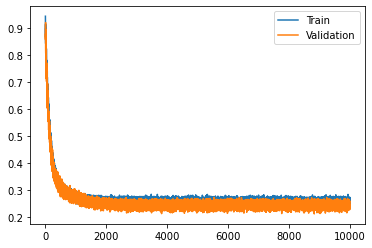

In [63]:
a = [np.mean(loss_100[i]) for i in range(len(loss_100))]
b = [np.mean(loss_t_100[i]) for i in range(len(loss_t_100))]
plt.plot(a, label = "Train")
plt.plot(b, label = "Validation")
plt.legend()

In [64]:
mses = []
loss_fn = nn.MSELoss()
for i in range(len(test)): 
    predictions = out_model(torch.FloatTensor(test[i][0]))

    mses.append(loss_fn(predictions, torch.FloatTensor(test[i][1])))



for i in range(len(mses)):
    mses[i] = mses[i].detach().numpy()

print(str(np.mean(mses)) + ' +- ' + str(np.std(mses)))

0.24723612 +- 0.10227571


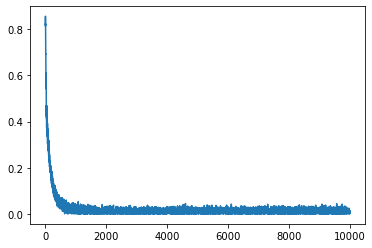

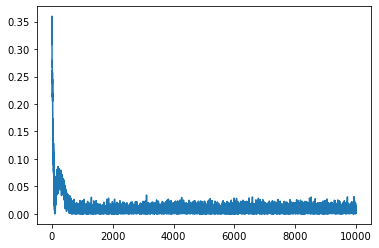

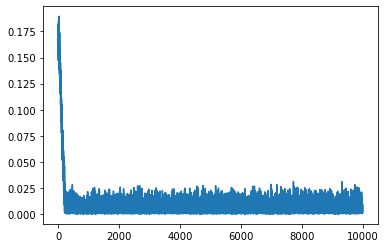

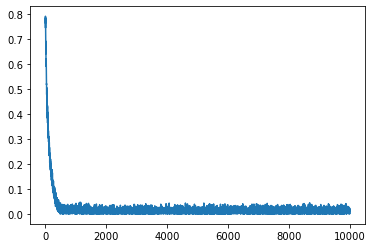

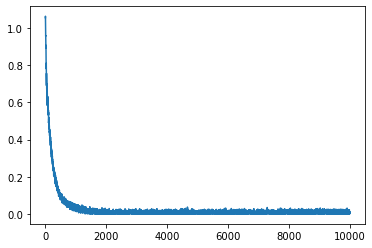

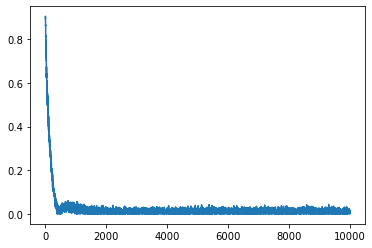

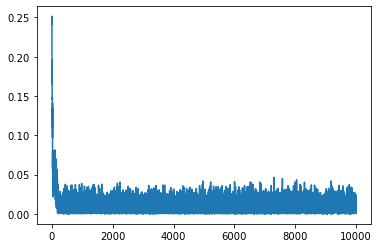

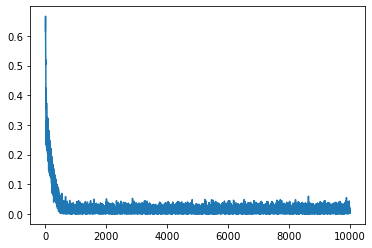

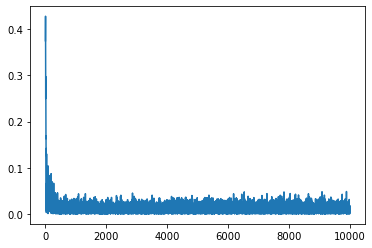

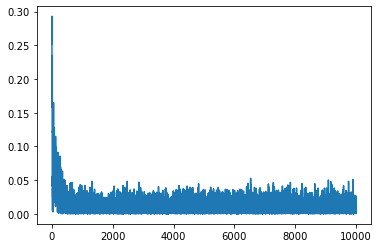

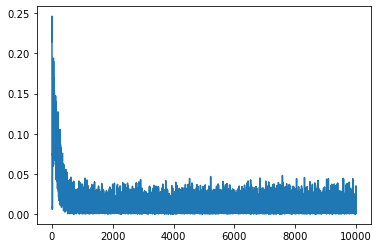

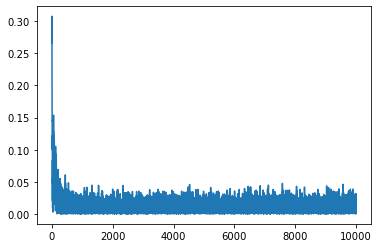

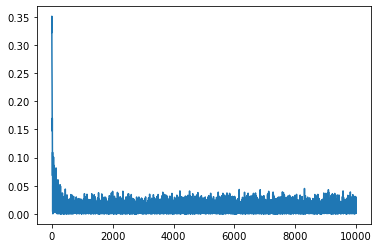

In [114]:
for i in range(0,13):
    al = np.stack(hist, axis=0)[:,0][:,i]
    plt.figure()
    plt.plot(range(0,len(al)), np.abs(al))


## The Fed SGD function 

In [61]:
def fed_sgd(data, test, iterations, N, S, n_feat):
    
    grad_mean_hist = []
    
    #Definition of the server model
    model_server = nn.Linear(n_feat, 1)
    optimizer_server = optim.Adam(model_server.parameters())
    loss_fn = nn.MSELoss()


    #One model per clients
    models = [None]*N
    opti = [None]*N
    loss_fct = [None]*N

    for i in range(len(models)):
        models[i] = nn.Linear(n_feat, 1)
        opti[i] = optim.Adam(models[i].parameters())
        loss_fct[i] = nn.MSELoss()

    mse = []
    mse_test = []
    #Iterations
    for i in range(0,iterations):

        #Random selection of clients
        a = list(range(0,N))
        sel = random.sample(a,S)

        grad = []
        bias = []
        loc = 0

        loss = [None]*S
        loss_test = [None]*S
        losses = 0

        #Clients iteration
        for j in sel:
            opti[loc].zero_grad()
            models[loc].weight = model_server.weight
            models[loc].weight.grad = None
            models[loc].bias = model_server.bias
            models[loc].bias.grad = None

            predictions = models[loc](data[j][0])
            loss[loc] = loss_fct[loc](predictions, data[j][1])
            loss[loc].backward()
            
            pred_test = models[loc](test[j][0])
            loss_test[loc] = loss_fct[loc](pred_test, test[j][1])

            loss[loc] = loss[loc].item()
            loss_test[loc] = loss_test[loc].item()
            
            grad.append(models[loc].weight.grad.numpy())
            bias.append(models[loc].bias.grad.numpy())
            loc+=1
            
        mse.append((loss))    
        mse_test.append((loss_test))
        
        grad = np.stack(grad, axis=0)
        grad_mean = torch.FloatTensor(grad.mean(axis = 0))
        
        grad_mean_hist.append(grad_mean)
        

        bias_mean = torch.FloatTensor([np.mean(bias)])
        model_server.weight.grad = grad_mean
        model_server.bias.grad = bias_mean
        optimizer_server.step()
        torch.nn.utils.clip_grad_norm_(parameters=model_server.parameters(), max_norm=10, norm_type=2.0)
    return model_server, mse, mse_test, grad_mean_hist


## Federated SGD with Neural Network 

### N = 150

In [71]:
data = []
test = []
df = [None]*len(dfs_big)


for i in range(len(dfs_big)):
    df[i] = dfs_big[i].sample(n = 150)
    X = df[i].loc[:, df[i].columns != 'pred']


    y = df[i].loc[:, df[i].columns == 'pred']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    
    data.append((X_train.to_numpy(),y_train.to_numpy()))
    test.append((X_test.to_numpy(),y_test.to_numpy()))

N = len(dfs_big)
iterations = 5000
S = 20
n_feat = 13
hidden_dim = 10

testing = [None]*len(test)

for i in range(len(data)): 
    x_i = torch.FloatTensor(data[i][0])
    y_i = torch.FloatTensor(data[i][1])
    x_t_i = torch.FloatTensor(test[i][0])
    y_t_i = torch.FloatTensor(test[i][1])
    data[i] = (x_i,y_i)
    testing[i] = (x_t_i,y_t_i)



In [55]:
mses = []
loss_fn = nn.MSELoss()
for i in range(len(test)): 
    predictions = out_mod(torch.FloatTensor(test[i][0]))

    mses.append(loss_fn(predictions, torch.FloatTensor(test[i][1])))



for i in range(len(mses)):
    mses[i] = mses[i].detach().numpy()

print(str(np.mean(mses)) + ' +- ' + str(np.std(mses)))

0.18149361 +- 0.06840297


## Varying hidden layer size 

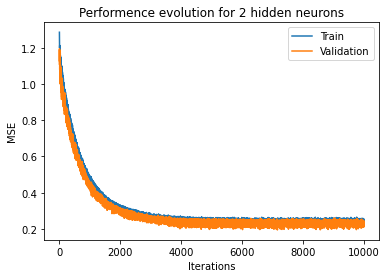

In [65]:
#2 neurons
out_mod, loss,loss_valid,hist = fed_sgd_nn(data, testing, iterations, N, S, n_feat, 2)

a = [np.mean(loss[i]) for i in range(len(loss))]
b = [np.mean(loss_valid[i]) for i in range(len(loss))]
plt.plot(a, label = "Train")
plt.plot(b, label = "Validation")
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.title('Performence evolution for 2 hidden neurons')

plt.legend()

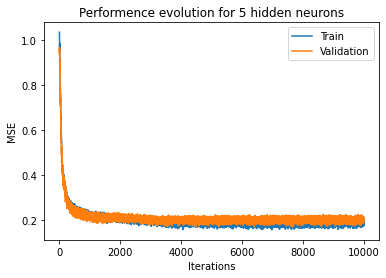

In [66]:
#5 neurons
out_mod, loss,loss_valid,hist = fed_sgd_nn(data, testing, iterations, N, S, n_feat, 5)

a = [np.mean(loss[i]) for i in range(len(loss))]
b = [np.mean(loss_valid[i]) for i in range(len(loss))]
plt.plot(a, label = "Train")
plt.plot(b, label = "Validation")
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.title('Performence evolution for 5 hidden neurons')
plt.legend()

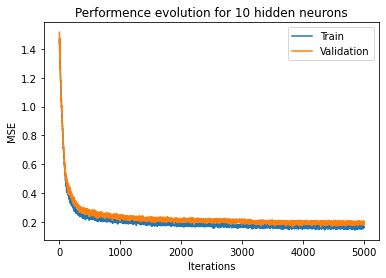

In [72]:
#10 neurons
out_mod, loss,loss_valid,hist = fed_sgd_nn(data, testing, iterations, N, S, n_feat, 10)

a = [np.mean(loss[i]) for i in range(len(loss))]
b = [np.mean(loss_valid[i]) for i in range(len(loss))]
plt.plot(a, label = "Train")
plt.plot(b, label = "Validation")
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.title('Performence evolution for 10 hidden neurons')
plt.legend()

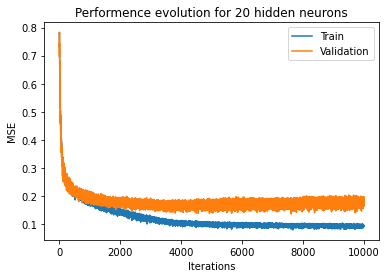

In [68]:
#20 Neurons
out_mod, loss,loss_valid,hist = fed_sgd_nn(data, testing, iterations, N, S, n_feat, 20)

a = [np.mean(loss[i]) for i in range(len(loss))]
b = [np.mean(loss_valid[i]) for i in range(len(loss))]
plt.plot(a, label = "Train")
plt.plot(b, label = "Validation")
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.title('Performence evolution for 20 hidden neurons')
plt.legend()

In [73]:
out_mod_2, l,l,h = fed_sgd_nn(data, testing, iterations, N, S, n_feat, 2)
out_mod_5, l,l,h = fed_sgd_nn(data, testing, iterations, N, S, n_feat, 5)
out_mod_10, l,l,h = fed_sgd_nn(data, testing, iterations, N, S, n_feat, 10)
out_mod_20, l,l,h = fed_sgd_nn(data, testing, iterations, N, S, n_feat, 20)




In [74]:
z = [out_mod_2,out_mod_5,out_mod_10,out_mod_20]

0.23448564 +- 0.0862418
0.19117013 +- 0.07251592
0.21948384 +- 0.10773186
0.15950535 +- 0.073732816


<ErrorbarContainer object of 3 artists>

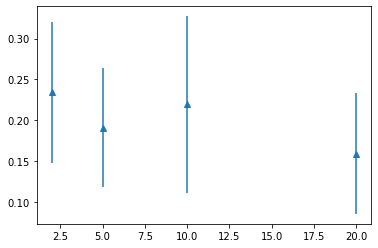

In [79]:
u = [2,5, 10, 20]
m = []
e = []
for j in range(len(z)):
    mses = []
    loss_fn = nn.MSELoss()
    for i in range(len(test)): 
        predictions = z[j](torch.FloatTensor(test[i][0]))

        mses.append(loss_fn(predictions, torch.FloatTensor(test[i][1])))



    for i in range(len(mses)):
        mses[i] = mses[i].detach().numpy()
        
    m.append(np.mean(mses))
    e.append(np.std(mses))

    print(str(np.mean(mses)) + ' +- ' + str(np.std(mses)))
    
    
plt.errorbar(u,m,yerr=e,linestyle='None', marker='^')

## Fed SGD with non-linear Neural Network

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        
        self.layer_2 = nn.Linear(hidden_dim, output_dim)
       
    def forward(self, x):
        x = torch.nn.functional.relu(self.layer_1(x))
        x = self.layer_2(x)
        return x

    

def fed_sgd_nn(data, test, iterations, N, S, n_feat, hidden_dim):
    
    grad_mean_hist = [None]*iterations
    
    #Definition of the server model
    model_server = NeuralNetwork(n_feat, hidden_dim, 1)
    optimizer_server = optim.Adam(model_server.parameters())
    loss_fn = nn.MSELoss()

    
    #One model per clients
    models = [None]*S
    opti = [None]*S
    loss_fct = [None]*S

    for i in range(len(models)):
        models[i] = NeuralNetwork(n_feat, hidden_dim, 1)
        
        opti[i] = optim.Adam(models[i].parameters())
        loss_fct[i] = nn.MSELoss()

        
    mse = []
    mse_test = []
    #Iterations
    for i in range(0,iterations):


        
        #Random selection of clients
        a = list(range(0,N))
        sel = random.sample(a,S)
        
        
        grad_l1 = []
        bias_l1 = []
        
        
        grad_l2 = []
        bias_l2 = []
        
        loc = 0

        loss = [None]*S
        loss_test = [None]*S

        #Clients iteration
        for j in sel:
            #First layer
            
            models[loc].layer_1.weight = model_server.layer_1.weight
            
            #print(models[loc].layer_1.weight)
            models[loc].layer_1.weight.grad = None
            models[loc].layer_1.bias = model_server.layer_1.bias
            models[loc].layer_1.bias.grad = None
            
            opti[loc].zero_grad()
            
            #print(models[loc].layer_1.bias)
            
            #Second layer
            
            models[loc].layer_2.weight = model_server.layer_2.weight
            models[loc].layer_2.weight.grad = None
            models[loc].layer_2.bias = model_server.layer_2.bias
            models[loc].layer_2.bias.grad = None

            predictions = models[loc](data[j][0])
            
            predi_test = models[loc](test[j][0])
            

            
            loss[loc] = loss_fct[loc](predictions, data[j][1])
            loss_test[loc] = loss_fct[loc](predi_test, test[j][1])
            
            #print(loss[loc])
            
            loss[loc].backward(retain_graph = True)
            
            
            loss[loc] = loss[loc].item()
            loss_test[loc] = loss_test[loc].item()
            #print(models[loc].layer_1.weight.grad)

            grad_l1.append(models[loc].layer_1.weight.grad.numpy())
            bias_l1.append(models[loc].layer_1.bias.grad.numpy())
            

            
            grad_l2.append(models[loc].layer_2.weight.grad.numpy())
            bias_l2.append(models[loc].layer_2.bias.grad.numpy())
            
            loc+=1
        
        #print(grad_l1)
        mse.append((loss))
        mse_test.append((loss_test))
        grad_l1 = np.stack(grad_l1, axis=0)

        grad_l2 = np.stack(grad_l2, axis=0)
        
        grad_mean_l1 = torch.FloatTensor(grad_l1.mean(axis = 0))
        

        
        grad_mean_l2 = torch.FloatTensor(grad_l2.mean(axis = 0))
        #print(grad_mean_l1)
        grad_mean_hist[i] = grad_mean_l1
        #print("errr")
        #print(grad_mean_hist)
        
        bias_l1 = np.stack(bias_l1, axis = 0)
        bias_mean_l1 = torch.FloatTensor(bias_l1.mean(axis = 0))
        bias_mean_l2 = torch.FloatTensor([np.mean(bias_l2)])
        
        
        model_server.layer_1.weight.grad = grad_mean_l1
        #print(model_server.layer_1.weight.grad)
        model_server.layer_2.weight.grad = grad_mean_l2

        model_server.layer_1.bias.grad = bias_mean_l1
        model_server.layer_2.bias.grad = bias_mean_l2
        
        optimizer_server.step()
    return model_server, mse, mse_test, grad_mean_hist